## Extended Kalman Filter (EKF) with Constant Turn Rate and Acceleration (CTRA) model

In [32]:
# Requisitos
import pandas as pd
import numpy as np

import scipy
import scipy.linalg
from scipy import stats
from scipy.stats import norm

import sympy
from sympy import init_printing
from sympy.utilities.codegen import codegen
from sympy import Symbol, symbols, Matrix, sin, cos

import webbrowser #hiperlink
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
init_printing(use_latex=True)

## Projeto cinemático do modelo uniciclo com correção de bias (CTRA)

![](uniciclo.png)

### Vetor de estados

$$ \mathbf{x} = \begin{bmatrix} x \\ y \\ \theta \\ v \\ b_{a} \\ b_{\psi} \end{bmatrix} = \begin{bmatrix} \text{Posição no eixo x} \\ \text{Posição no eixo y} \\ \text{Orientação do veículo no eixo z} \\ \text{Velocidade linear} \\ \text{Bias da aceleração} \\ \text{Bias do giroscópio}\end{bmatrix} $$

### Vetor de entrada

$$ \mathbf{u} = \begin{bmatrix} a \\ \psi \end{bmatrix} = \begin{bmatrix} \text{Aceleração no eixo x} \\ \text{Rotação no eixo z} \end{bmatrix} $$

## Sistema dinâmico não-linear a ser rastreado

$$ \mathbf{x}_{k} = \mathbf{f}(\mathbf{x}_{k-1}, \mathbf{u}_k) + w_k + \tau_k $$

### Ruído nos vetores de estado e controle

Ruídos são variáveis aleatórias com normal de média nula, sendo a influência dos ruídos filtrada pelas covariâncias. É a solução estocástica ótima!

$$ w_k = \mathcal{N}(0, Q) $$

$$ \tau_k = \mathcal{N}(0, M) $$

## Sistema linearizado por série de Taylor

O sistema não-linear estocástico pode ser linearizado e descrito por meio de equações cinemáticas:

$$ \mathbf{x}_k = \begin{bmatrix} x_k \\ y_k \\ \theta_k \\ v_k \\ b_{a_{k}} \\ b_{\psi_{k}} \end{bmatrix} \implies \mathbf{x}_{k} = \begin{bmatrix} x_{k-1} \\ y_{k-1} \\ \theta_{k-1} \\ v_{k-1} \\ b_{a_{k-1}} \\ b_{\psi_{k-1}} \end{bmatrix} + \begin{bmatrix} v_{k-1}\cdot\cos(\theta_{k-1})\cdot \Delta t \\ v_{k-1}\cdot\sin(\theta_{k-1})\cdot \Delta t \\ (\psi_{k-1} - b_{\psi_{k-1}})\cdot \Delta t \\ (a_{k-1} - b_{a_{k-1}})\cdot \Delta t \\ -b_{a_{k-1}}\cdot \tau_{b_a}^{-1} \cdot \Delta t \\ -b_{\psi_{k-1}}\cdot \tau_{b_\psi}^{-1} \cdot \Delta t \end{bmatrix} $$

Para facilitar as operações foi adotado a seguinte notação:

$$ \mathbf{f}(x_{k-1}, u_k) = \begin{bmatrix} f_1 \\ f_2 \\ f_3 \\ f_4 \\ f_5 \\ f_6 \end{bmatrix} = \begin{bmatrix} x_{k-1} + v_{k-1}\cdot\cos(\theta_{k-1}) \cdot \Delta t\\ y_{k-1} + v_{k-1}\cdot\sin(\theta_{k-1}) \cdot \Delta t\\ \theta_{k-1} + (\psi_{k-1} - b_{\psi_{k-1}}) \cdot \Delta t\\ v_{k-1} + (a_{k-1} - b_{a_{k-1}}) \cdot \Delta t\\ b_{a_{k-1}} - b_{a_{k-1}}\cdot \tau_{b_a}^{-1} \cdot \Delta t\\ b_{\psi_{k-1}} - b_{\psi_{k-1}}\cdot \tau_{b_\psi}^{-1} \cdot \Delta t\end{bmatrix} $$

$\mathbf{F}_k$ é a matriz Jacobiana de $f(x_{k-1}, u_k)$ com relação ao vetor de estados.

$$
\mathbf{F}_k = \frac{\partial f(x_{k-1}, u_k)}{\partial x_{k-1}} \implies \mathbf{F}_k = \begin{bmatrix}
\frac{\partial f_1}{\partial x} & 
\frac{\partial f_1}{\partial y} &
\frac{\partial f_1}{\partial \theta} &
\frac{\partial f_1}{\partial v} &
\frac{\partial f_1}{\partial b_{a}} &
\frac{\partial f_1}{\partial b_{\psi}}\\
\frac{\partial f_2}{\partial x} & 
\frac{\partial f_2}{\partial y} &
\frac{\partial f_2}{\partial \theta} &
\frac{\partial f_2}{\partial v} &
\frac{\partial f_2}{\partial b_{a}} &
\frac{\partial f_2}{\partial b_{\psi}}\\
\frac{\partial f_3}{\partial x} & 
\frac{\partial f_3}{\partial y} &
\frac{\partial f_3}{\partial \theta} &
\frac{\partial f_3}{\partial v} &
\frac{\partial f_3}{\partial b_{a}} &
\frac{\partial f_3}{\partial b_{\psi}}\\
\frac{\partial f_4}{\partial x} & 
\frac{\partial f_4}{\partial y} &
\frac{\partial f_4}{\partial \theta} &
\frac{\partial f_4}{\partial v} &
\frac{\partial f_4}{\partial b_{a}} &
\frac{\partial f_4}{\partial b_{\psi}}\\
\frac{\partial f_5}{\partial x} & 
\frac{\partial f_5}{\partial y} &
\frac{\partial f_5}{\partial \theta} &
\frac{\partial f_5}{\partial v} &
\frac{\partial f_5}{\partial b_{a}} &
\frac{\partial f_5}{\partial b_{\psi}}\\
\frac{\partial f_6}{\partial x} & 
\frac{\partial f_6}{\partial y} &
\frac{\partial f_6}{\partial \theta} &
\frac{\partial f_6}{\partial v} &
\frac{\partial f_6}{\partial b_{a}} &
\frac{\partial f_6}{\partial b_{\psi}}
\end{bmatrix}
$$

$$
\mathbf{F}_k =\begin{bmatrix}
1 & 
0 &
-v_{k-1}\cdot\sin(\theta_{k-1})\cdot \Delta t &
\cos(\theta_{k-1})\cdot \Delta t &
0 &
0 \\
0 & 
1 &
v_{k-1}\cdot\cos(\theta_{k-1})\cdot \Delta t &
\sin(\theta_{k-1})\cdot \Delta t &
0 &
0 \\
0 & 
0 &
1 &
0 &
0 &
-\Delta t \\
0 &
0 &
0 &
1 &
-\Delta t &
0 \\
0 &
0 &
0 &
0 &
1-\tau_{ba}^{-1}\cdot \Delta t &
0 \\
0 &
0 &
0 &
0 &
0 &
1-\tau_{b\psi}^{-1}\cdot \Delta t
\end{bmatrix}
$$

$\mathbf{G}_k$ é a matriz Jacobiana de $f(x_{k-1}, u_k)$ com relação ao vetor de controle.

$$\mathbf{G}_k = \frac{\partial f(x_{k-1}, u_{k})}{\partial u_{k}} \implies \mathbf{G}_k = \begin{bmatrix}
\frac{\partial f_1}{\partial a} & \frac{\partial f_1}{\partial \psi} \\
\frac{\partial f_2}{\partial a} & \frac{\partial f_2}{\partial \psi} \\
\frac{\partial f_3}{\partial a} & \frac{\partial f_3}{\partial \psi} \\
\frac{\partial f_4}{\partial a} & \frac{\partial f_4}{\partial \psi} \\
\frac{\partial f_5}{\partial a} & \frac{\partial f_5}{\partial \psi} \\
\frac{\partial f_6}{\partial a} & \frac{\partial f_6}{\partial \psi}
\end{bmatrix}$$

$$\mathbf{G}_k = \begin{bmatrix}
0 & 0 \\
0 & 0 \\
0 & \Delta t \\
\Delta t & 0 \\
0 & 0 \\
0 & 0 
\end{bmatrix}$$

## Matriz de covariância de ruídos do sistema de posições

$$\mathbf{Q} = \begin{bmatrix}
\sigma_{x}^{2} & 0 & 0 & 0 & 0 & 0\\
0 & \sigma_{y}^{2} & 0 & 0 & 0 & 0\\
0 & 0 & \sigma_{\theta}^{2} & 0 & 0 & 0\\
0 & 0 & 0 & \sigma_{v}^{2} & 0 & 0\\
0 & 0 & 0 & 0 & \sigma_{b_a}^{2} & 0 \\
0 & 0 & 0 & 0 & 0 & \sigma_{b_\psi}^{2}
\end{bmatrix}$$

## Matriz de covariância de ruídos dos sinais de controle de movimento

Controle de erro nas variáveis de entrada $a$ e $\psi$ convertido em controle de erro nas variáveis de estado $x$, $y$, $\theta$ e $v$.

$$\mathbf M = \begin{bmatrix}
\sigma_{a}^{2} & 0 \\
0 & 
\sigma_{\psi}^{2}
\end{bmatrix}
$$

## Matriz de covariância de estado 

Associa-se a origem do veículo.

-Certeza da origem:

$$\mathbf{P} = \begin{bmatrix}
0 & 0 & 0 & 0 & 0 & 0\\
0 & 0 & 0 & 0 & 0 & 0\\
0 & 0 & 0 & 0 & 0 & 0\\
0 & 0 & 0 & 0 & 0 & 0\\
0 & 0 & 0 & 0 & 0 & 0\\
0 & 0 & 0 & 0 & 0 & 0\\
\end{bmatrix}$$

-Valor arbitrado razoável (o filtro consegue corrigir em execução):

$$\mathbf{P} = \mathbf{Q} $$

-Valor arbitrado pelo professor:

$$\mathbf{P} = \begin{bmatrix}
10 & 0 & 0 & 0 & 0 & 0\\
0 & 10 & 0 & 0 & 0 & 0\\
0 & 0 & 10 & 0 & 0 & 0\\
0 & 0 & 0 & 10 & 0 & 0\\
0 & 0 & 0 & 0 & 10 & 0\\
0 & 0 & 0 & 0 & 0 & 10
\end{bmatrix}$$ 

## Sistema sensorial não-linear para observar $x_k$

$$ \mathbf{z}_k = \mathbf{h}(\mathbf{x}_k, v_k) $$

### Ruído no sistema sensorial

Ruídos são variáveis aleatórias com normal de média nula, sendo a influência dos ruídos filtrada pelas covariâncias. É a solução estocástica ótima!

$$ v_k = \mathcal{N}(0, R) $$

## Sistema sensorial linearizado

$$\mathbf{z}_{k} = \begin{bmatrix}
x_{gps,k} \\
y_{gps,k}
\end{bmatrix}$$ 

Para facilitar as operações foi adotado a seguinte notação:

$$ \mathbf{h}(x_{k}) = \begin{bmatrix} h_1 \\ h_2 \end{bmatrix} = \begin{bmatrix}
x_{gps, k} \\
y_{gps, k}
\end{bmatrix}$$

$\mathbf{H}_k$ é a matriz Jacobiana de $h(x_{k})$ com relação ao vetor de estados.

$$\mathbf{H}_k = \frac{\partial h(x_{k})}{\partial x_{k-1}} \implies \mathbf{H}_k = \begin{bmatrix}
\frac{\partial h_1}{\partial x} & 
\frac{\partial h_1}{\partial y} &
\frac{\partial h_1}{\partial \theta} & 
\frac{\partial h_1}{\partial v} &
\frac{\partial h_1}{\partial b_{a}} &
\frac{\partial h_1}{\partial b_{\psi}} \\
\frac{\partial h_2}{\partial x} & 
\frac{\partial h_2}{\partial y} &
\frac{\partial h_2}{\partial \theta} & 
\frac{\partial h_2}{\partial v} &
\frac{\partial h_2}{\partial b_{a}} &
\frac{\partial h_2}{\partial b_{\psi}}
\end{bmatrix}$$

$$ \mathbf{H}_{k} = \begin{bmatrix}
1 & 0 & 0 & 0 & 0 & 0\\
0 & 1 & 0 & 0 & 0 & 0
\end{bmatrix}$$

## Esperança do sistema sensorial linearizado

$$\mathbf{h}_{k|k-1} = \begin{bmatrix}
x_{gps, k|k-1} \\
y_{gps, k|k-1}
\end{bmatrix}$$

## Matriz de covariância do sensor

$$ \mathbf{R} = \begin{bmatrix}
\sigma_{zx}^{2} & 0 \\
0 & 
\sigma_{zy}^{2}
\end{bmatrix}$$

## Matriz identidade

$$\mathbf{I} = \begin{bmatrix}
1 & 0 & 0 & 0 & 0 & 0\\
0 & 1 & 0 & 0 & 0 & 0\\
0 & 0 & 1 & 0 & 0 & 0\\
0 & 0 & 0 & 1 & 0 & 0\\
0 & 0 & 0 & 0 & 1 & 0\\
0 & 0 & 0 & 0 & 0 & 1\\
\end{bmatrix}$$

# Equações de previsão das esperanças

### Leitura do sistema sensorial

$$ \mathbf{z}_{k} = \begin{bmatrix}
x_{gps,k} \\
y_{gps,k}
\end{bmatrix} $$ 

### Estimativa do vetor de estados

$$\mathbf{x}_{k} = \mathbf{x}_{k-1} + \begin{bmatrix} v_{k-1}\cdot\cos(\theta_{k-1})\cdot \Delta t \\ v_{k-1}\cdot\sin(\theta_{k-1})\cdot \Delta t \\ (\psi_{k-1} - b_{\psi_{k-1}})\cdot \Delta t \\ (a_{k-1} - b_{a_{k-1}})\cdot \Delta t \\ -b_{a_{k-1}}\cdot \tau_{b_a}^{-1} \cdot \Delta t \\ -b_{\psi_{k-1}}\cdot \tau_{b_\psi}^{-1} \cdot \Delta t \end{bmatrix} $$

### Estimativa da covariância de erro

$$ \mathbf{P}_{k|k-1} = \mathbf{F}_{k}\mathbf{P}_{k-1|k-1}\mathbf{F}_{k}^{T} + \mathbf{G}_{k}\mathbf{M}_{k-1}\mathbf{G}_{k}^{T} + \mathbf{Q}_{k} $$

### Esperança do sistema sensorial

$$\mathbf{h}_{k|k-1} = \begin{bmatrix}
x_{gps, k|k-1} \\
y_{gps, k|k-1}
\end{bmatrix}$$

# Equações de correção das esperanças

### Ganho de Kalman

Método dos mínimos quadrados.

$$ \mathbf{K}_{k} = \mathbf{P}_{k|k-1}\mathbf{H}_{k}^{T}(\mathbf{H}_{k}\mathbf{P}_{k|k-1}\mathbf{H}_{k}^{T} + \mathbf{R}_{k})^{-1} $$

### Correção do vetor de estados

$$ \mathbf{x}_{k|k} = \mathbf{x}_{k|k-1} + \mathbf{K}_{k}(\mathbf{z}_{k}-\mathbf{h}_{k|k-1}) $$

### Correção da covariância do erro

$$ \mathbf{P}_{k|k} = (\mathbf{I} - \mathbf{K}_{k}\mathbf{H}_{k})\mathbf{P}_{k|k-1} $$

# Conjunto de dados

In [33]:
#dt = 1.0/50.0
dt = 1.0

In [34]:
data1 = "tabelas_ajustadas/1_pos.csv"
data1 = pd.read_csv(data1, sep=',')
data1

,timestamp,location_x,location_y,location_z,velocity_x,velocity_y,velocity_z,acceleration_x,acceleration_y,acceleration_z,...,rotation_pitch,rotation_yaw,rotation_roll,control_throttle,control_steer,control_brake,control_hand_brake,control_reverse,control_manual_gear_shift,control_gear
0,1.723485e+07,-85.146828,-103.282997,-0.441879,0.000001,0.000009,-0.001375,-4.345707e-07,0.000026,0.006870,...,-1.311342,89.843384,-0.000427,0.700000,1.192093e-10,0.0,False,False,False,0
1,1.723485e+07,-85.146828,-103.282997,-0.441846,0.000001,0.000063,0.000821,4.453535e-06,0.000877,0.036066,...,-1.311342,89.843384,-0.000427,0.700000,1.192093e-10,0.0,False,False,False,0
2,1.723485e+07,-85.146828,-103.282997,-0.441835,0.000002,0.000075,0.001317,4.240104e-05,0.001542,0.059755,...,-1.311342,89.843384,-0.000427,0.700000,1.192093e-10,0.0,False,False,False,0
3,1.723485e+07,-85.146828,-103.282997,-0.441835,0.000002,0.000075,0.001317,4.240104e-05,0.001542,0.059755,...,-1.311342,89.843384,-0.000427,0.700000,1.192093e-10,0.0,False,False,False,0
4,1.723485e+07,-85.146828,-103.282997,-0.441816,0.000001,0.000052,0.000562,-8.256954e-07,-0.000103,-0.003501,...,-1.311403,89.843391,-0.000336,0.700000,1.192093e-10,0.0,False,False,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7915,1.723515e+07,109.633873,61.983776,0.001747,4.872616,-0.036871,0.000308,6.137717e-04,0.102104,-0.008180,...,-0.000273,-0.898102,-0.004822,0.379340,1.428775e-02,0.0,False,False,False,1
7916,1.723515e+07,110.051079,61.980408,0.001653,4.872650,-0.025654,-0.000464,3.953680e-04,0.130995,-0.009022,...,-0.000273,-0.769348,-0.005188,0.379340,1.462420e-02,0.0,False,False,False,1
7917,1.723515e+07,110.110359,61.980003,0.001690,4.872658,-0.024269,0.002860,6.271852e-04,0.113847,0.273294,...,-0.000273,-0.751068,-0.005249,0.379341,1.440677e-02,0.0,False,False,False,1
7918,1.723515e+07,110.129623,61.979877,0.001706,4.872660,-0.023804,0.004028,4.822504e-04,0.117362,0.295155,...,-0.000273,-0.745148,-0.005249,0.379341,1.440677e-02,0.0,False,False,False,1


In [35]:
speed = data1['velocity_x']
steering = data1['control_steer']
angular_velocity = data1['angular_velocity_x']

In [36]:
data2 = "tabelas_ajustadas/2_gnssGT.csv"
data2 = pd.read_csv(data2, sep=',')
data2

,timestamp,latitude,longitude,altitude
0,1.723485e+07,0.000928,-0.000765,-0.441879
1,1.723485e+07,0.000928,-0.000765,-0.441846
2,1.723485e+07,0.000928,-0.000765,-0.441835
3,1.723485e+07,0.000928,-0.000765,-0.441821
4,1.723485e+07,0.000928,-0.000765,-0.441816
...,...,...,...,...
7915,1.723515e+07,-0.000557,0.000985,0.001747
7916,1.723515e+07,-0.000557,0.000989,0.001653
7917,1.723515e+07,-0.000557,0.000989,0.001690
7918,1.723515e+07,-0.000557,0.000989,0.001706


In [37]:
gt_time = data2['timestamp'] 
latitudeGT = data2['latitude'] # deg
longitudeGT = data2['longitude'] # deg
altitudeGT = data2['altitude'] # m

In [38]:
data3 = "tabelas_ajustadas/3_gnss.csv"
data3 = pd.read_csv(data3, sep=',')
data3

,timestamp,latitude,longitude,altitude
0,17234845.69,0.000917,-0.000763,-0.441846
1,17234845.70,0.000944,-0.000768,-0.441734
2,17234846.08,0.000922,-0.000764,-0.441785
3,17234846.15,0.000930,-0.000770,-0.441683
4,17234846.15,0.000923,-0.000768,-0.441724
...,...,...,...,...
7915,17235149.96,-0.000556,0.000986,0.001539
7916,17235149.96,-0.000560,0.000988,0.001653
7917,17235149.97,-0.000558,0.000993,0.001773
7918,17235150.01,-0.000543,0.000995,0.001831


In [39]:
gnss_time = data3['timestamp']
latitude = data3['latitude'] # graus
longitude = data3['longitude'] # graus
altitude = data3['altitude'] # metros

In [40]:
data4 = "tabelas_ajustadas/4_imu.csv"
data4 = pd.read_csv(data4, sep=',')
data4

,timestamp,accelerometer_x,accelerometer_y,accelerometer_z,gyroscope_x,gyroscope_y,gyroscope_z,compass
0,17234846.08,3.138852,1.557610e+06,-1.277423e+06,42327.644530,0.009200,-0.001870,0.004808
1,17234846.15,3.138852,-2.194956e-01,-2.147567e-03,9.797777,0.001122,-0.003023,0.002080
2,17234846.15,3.138852,-2.247930e-01,3.140000e-05,9.814496,0.006288,0.001726,-0.004286
3,17234846.15,3.138852,-2.272361e-01,-1.510000e-05,9.926997,0.002527,-0.001481,0.003466
4,17234846.15,3.138852,-5.401890e-01,1.589932e-01,9.600149,0.002700,-0.001089,-0.008307
...,...,...,...,...,...,...,...,...
7915,17235150.01,1.558921,2.158444e-02,-1.291774e-01,9.748857,-0.003951,-0.004420,0.010777
7916,17235150.01,1.559230,5.739890e-04,-4.969786e-02,9.863008,-0.000793,-0.000975,0.008724
7917,17235150.01,1.559230,5.739890e-04,-4.969786e-02,9.863008,-0.000793,-0.000975,0.008724
7918,17235150.03,1.559530,-3.983101e-02,-2.029559e-02,9.790447,0.006141,0.005546,0.014458


In [41]:
imu_time = data4['timestamp']
acceleration = data4['accelerometer_x'] # m/s^2

#pitch = data4['gyroscope_y'] # rad/s
yawrate = data4['gyroscope_z'] # rad/s
#roll = data4['gyroscope_x'] # rad/s

zenith = data4['compass'] # rad

# (pitch, yaw, roll) = (Y-rotation,Z-rotation,X-rotation)

## Heading a partir do Yawrate

In [42]:
course = np.array([yawrate[0] * dt])
n = yawrate.shape[0] - 1
for step in range(n):
    course = np.append(course, (course[step] + yawrate[step+1] * dt + np.pi) % (2.0*np.pi) - np.pi)

# Análise    
lim = course.shape[0] - 1
l1 = np.empty_like(course)
for i in range(1,lim):
    l1[i-1] = course[i]-course[i-1]

l1 = np.absolute(l1)
print(stats.describe(l1))

DescribeResult(nobs=7920, minmax=(1.537698765072e-311, 0.10927681599999994), mean=0.004947960701010102, variance=2.6133715804985288e-05, skewness=4.929594519812832, kurtosis=51.51041845880268)


# Conversão de coordenadas (UTM)

In [43]:
RadiusEarth = 6378388.0 # m
arc= 2.0*np.pi*(RadiusEarth+altitude)/360.0 # m/°
arcGT= 2.0*np.pi*(RadiusEarth+altitudeGT)/360.0 # m/°

# Projeção cilíndrica equidistante
# x = r * cos(latitude)*(longitude_{K} - longitude_{K-1})
# y = r * (latitude_{K} - latitude_{K-1})
dx = arc * np.cos(latitude*np.pi/180.0) * np.hstack((0.0, np.diff(longitude))) # metros
dy = arc * np.hstack((0.0, np.diff(latitude))) # metros

dxGT = arcGT * np.cos(latitudeGT*np.pi/180.0) * np.hstack((0.0, np.diff(longitudeGT))) # metros
dyGT = arcGT * np.hstack((0.0, np.diff(latitudeGT))) # metros

mx = np.cumsum(dx)
my = np.cumsum(dy)
mxGT = np.cumsum(dxGT)
myGT = np.cumsum(dyGT)

GNSS = (imu_time >= gnss_time).astype('bool')

# Distância Euclidiana
d = np.sqrt((mx - mxGT)**2 + (my - myGT)**2 )
# Análise    
lim = d.shape[0] - 1
l2 = np.empty_like(d)
for i in range(1,lim):
    l2[i-1] = d[i]-d[i-1]

l2 = np.absolute(d)
print(stats.describe(l2))

DescribeResult(nobs=7920, minmax=(0.0, 5.324248735806829), mean=1.675211031763029, variance=0.6607193683396446, skewness=0.4768882884332104, kurtosis=-0.02338532133474258)


In [44]:
measurements = np.vstack((mx, my))
# Lenth of the measurement
m = measurements.shape[1]

In [45]:
# Para plotagem
x0     = []
x1     = []
x2     = []
x3     = []
x4     = []
Zx     = []
Zy     = []
Px     = []
Py     = []
Ppsi   = []
Pv     = []
Pdpsi  = []
Kx     = []
Ky     = []
Kpsi   = []
Kv     = []
Kdpsi  = [] 
dstate = []
# Para plotagem da distância euclidiana
x0p    = [0]
x1p    = [0]
mxp    = [0]
myp    = [0]
mxGTp  = [0]
myGTp  = [0]
innov_x= []
innov_y= []

# Implementação do EKF em Python

In [46]:
class EKF():
    def __init__(self, dt):
        self.dt = dt
        self.biacx = 11.0
        self.bipsi = 4.5

        self.x = None
        self.F = None
        self.u = None
        self.G = None
        
        self.Q = None
        self.M = None
        self.P = None

        self.h = None
        self.z = None
        self.y = None
        self.H = None
        self.R = None
        self.K = None
        self.I = np.eye(6)
        
        # Suposições sobre a dinâmica do sistema
        self.noise_pxy = 0.5*2.0*self.dt**2
        self.noise_tht = 0.01*self.dt
        self.noise_vel = 4.0*self.dt
        # Correções de bias
        self.noise_bacx = 0.00001*self.dt
        self.noise_bpsi = 0.00003*self.dt
        # Desvios padrões dos sinais de controle
        self.noise_psi = 7.5*self.dt
        self.noise_acx = 8.0*self.dt
        # Desvios padrões das medições
        self.noise_gps = 3.0*0.7430356019596824
    
    def init_dynamic_system(self, psx, psy, tht, vel, acx, psi, bacx, bpsi):
        self.x = np.matrix([[psx, psy, tht, vel, bacx, bpsi]]).T # init_state
        self.u = np.matrix([[acx, psi]]).T # init_control
        
    def set_matrices(self, tht, vel):
        f13 = float(-vel*np.sin(tht)*self.dt)
        f14 = float(np.cos(tht)*self.dt)
        f23 = float( vel*np.cos(tht)*self.dt)
        f24 = float(np.sin(tht)*self.dt)
        
        f36 = float(-self.dt)
        f45 = float(-self.dt)
        f55 = float(1-(self.dt/self.biacx)) 
        f66 = float(1-(self.dt/self.bipsi)) 
        
        self.F = np.matrix([[1.0, 0.0, f13, f14, 0.0, 0.0],
                            [0.0, 1.0, f23, f24, 0.0, 0.0],
                            [0.0, 0.0, 1.0, 0.0, 0.0, f36],
                            [0.0, 0.0, 0.0, 1.0, f45, 0.0],
                            [0.0, 0.0, 0.0, 0.0, f55, 0.0],
                            [0.0, 0.0, 0.0, 0.0, 0.0, f66]])

        g32 = float(self.dt)
        g41 = float(self.dt)
        self.G = np.matrix([[0.0, 0.0],
                            [0.0, 0.0],
                            [0.0, g32],
                            [g41, 0.0],
                            [0.0, 0.0],
                            [0.0, 0.0]])
        
        self.Q = np.diag([(self.noise_pxy-0.5)**2, (self.noise_pxy)**2, self.noise_tht**2, self.noise_vel**2, self.noise_bacx**2, self.noise_bpsi**2])
        self.M = np.diag([self.noise_acx**2, self.noise_psi**2])
        self.H = np.matrix([[1.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                            [0.0, 1.0, 0.0, 0.0, 0.0, 0.0]])
        
        self.R = np.diag([self.noise_gps**2, self.noise_gps**2])
        self.P = np.diag([10.0, 10.0, 10.0, 10.0, 10.0, 10.0])
    
    def dynamic_system(self):
        x1 = self.x[0,0]+self.x[3,0]*np.cos(self.x[2,0])*self.dt
        x2 = self.x[1,0]+self.x[3,0]*np.sin(self.x[2,0])*self.dt
        x3 = self.x[2,0]+(self.u[1,0]-self.x[5,0])*self.dt
        x4 = self.x[3,0]+(self.u[0,0]-self.x[4,0])*self.dt
        # variáveis de estados para correção de bias
        x5 = self.x[4,0]-(self.x[4,0]/self.biacx)*self.dt
        x6 = self.x[5,0]-(self.x[5,0]/self.bipsi)*self.dt

        
        self.x = np.matrix([[x1, x2, x3, x4, x5, x6]]).T # state ahead
        self.u = self.u # control sign ahead
        
    def predict(self):
        f1 = self.x[3,0]*np.cos(self.x[2,0])*self.dt
        f2 = self.x[3,0]*np.sin(self.x[2,0])*self.dt
        f3 = (self.u[1,0]-self.x[5,0])*self.dt
        f4 = (self.u[0,0]-self.x[4,0])*self.dt
        # variáveis de estados para correção de bias
        f5 = -(self.x[4,0]/self.biacx)*self.dt
        f6 = -(self.x[5,0]/self.bipsi)*self.dt

        self.x = self.x + np.matrix([[f1, f2, f3, f4, f5, f6]]).T
        self.P = ((self.F)*(self.P)*(self.F.T))+((self.G)*(self.M)*(self.G.T))+self.Q
        return self.x, self.P
    
    def residual(self, filterstep):
        self.h = np.matrix([[float(self.x[0,0])],
                            [float(self.x[1,0])]])
        self.z = measurements[:,filterstep].reshape((self.H).shape[0],1)
        self.y = self.z-self.h
        return self.z, self.y
    
    def update(self):
        S = (self.H)*(self.P)*(self.H).T + self.R
        self.k = ((self.P)*(self.H).T)*np.linalg.inv(S)
        self.x = self.x + (self.k)*(self.y)
        self.P = (self.I - ((self.k)*(self.H)))*self.P
        return self.k, self.x, self.P

In [47]:
ekf = EKF(dt)

b1 = 0.01 # erro de bias da aceleração inicial
b2 = 0.03 # erro de bias do yawrate inicial

ekf.init_dynamic_system(mx[0],my[0],course[0],speed[0],acceleration[0],yawrate[0], b1, b2)
ekf.set_matrices(course[0],speed[0])
for filterstep in range(m):
    f,P = ekf.predict()
    z,y = ekf.residual(filterstep)
    k,f,P = ekf.update()
    
    
    # ===============================
    # Save states for Plotting
    # ===============================
    if GNSS[filterstep]:
        x0p.append(float(f[0]))
        x1p.append(float(f[1]))
        mxp.append(mx[filterstep])
        myp.append(my[filterstep])
        mxGTp.append(mxGT[filterstep])
        myGTp.append(myGT[filterstep])
    
    x0.append(float(f[0]))
    x1.append(float(f[1]))
    x2.append(float(f[2]))
    Zx.append(float(z[0]))
    Zy.append(float(z[1]))
    
    # Innovation
    innov_x.append(y[0,0])
    innov_y.append(y[1,0])
    
    # Covariance
    Px.append(float(P[0,0]))
    Py.append(float(P[1,1]))
    Ppsi.append(float(P[2,2]))
    
    # Kalman gain
    Kx.append(float(k[0,0]))
    Ky.append(float(k[1,0]))
    Kpsi.append(float(k[2,0]))

In [48]:
# Alocações para plotagem
pos_x = np.asarray(x0)
pos_y = np.asarray(x1)
pos_mx = np.asarray(mx)
pos_my = np.asarray(my)
pos_mxGT = np.asarray(mxGT)
pos_myGT = np.asarray(myGT)
# Alocações para plotagem e filtradas pelo timestamp
pos_xp = np.asarray(x0p)
pos_yp = np.asarray(x1p)
pos_mxp = np.asarray(mxp)
pos_myp = np.asarray(myp)
pos_mxGTp = np.asarray(mxGTp)
pos_myGTp = np.asarray(myGTp)

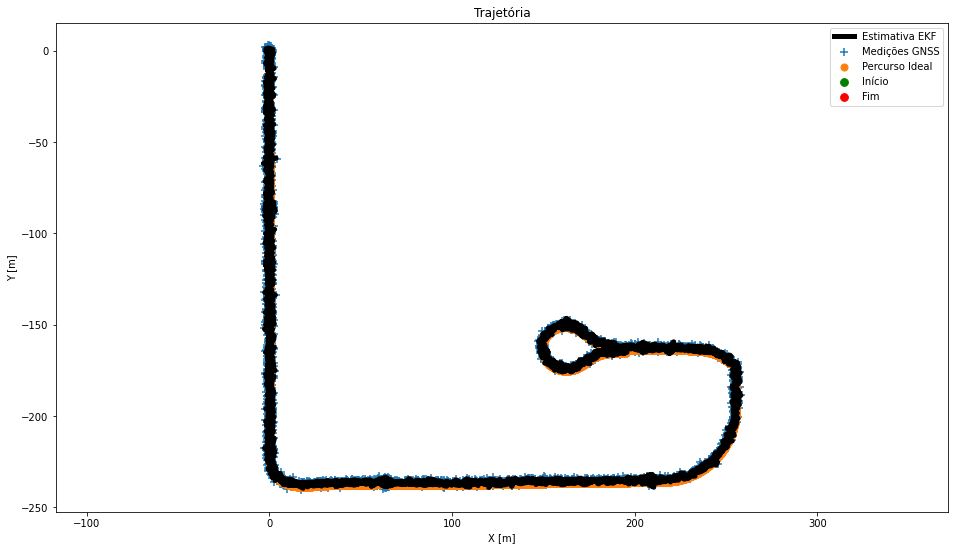

In [49]:
fig = plt.figure(figsize=(16,9))

# EKF State
plt.quiver(x0,x1,np.cos(x2), np.sin(x2), color='#94C600', units='xy', width=0.05, scale=0.5)
plt.plot(x0,x1, label='Estimativa EKF', c='k', lw=5)

# Measurements
plt.scatter(mx,my, s=50, label='Medições GNSS', marker='+')

# Ground Truth
plt.scatter(mxGT,myGT, s=50, label='Percurso Ideal', marker='o')

# Start/Goal
plt.scatter(x0[0],x1[0], s=60, label='Início', c='g')
plt.scatter(x0[-1],x1[-1], s=60, label='Fim', c='r')

plt.xlabel('X [m]')
plt.ylabel('Y [m]')
plt.title('Trajetória')
plt.legend(loc='best')
plt.axis('equal')

# Análise de Dados

In [50]:
# Calcular a distância euclidiana entre as estimativas e o ground truth
dep = np.sqrt((pos_xp - pos_mxGTp)**2 + (pos_yp - pos_myGTp)**2 )

In [51]:
# Calcular a distância euclidiana entre as medições e o ground truth
dmp = np.sqrt((pos_mxp - pos_mxGTp)**2 + (pos_myp - pos_myGTp)**2 )

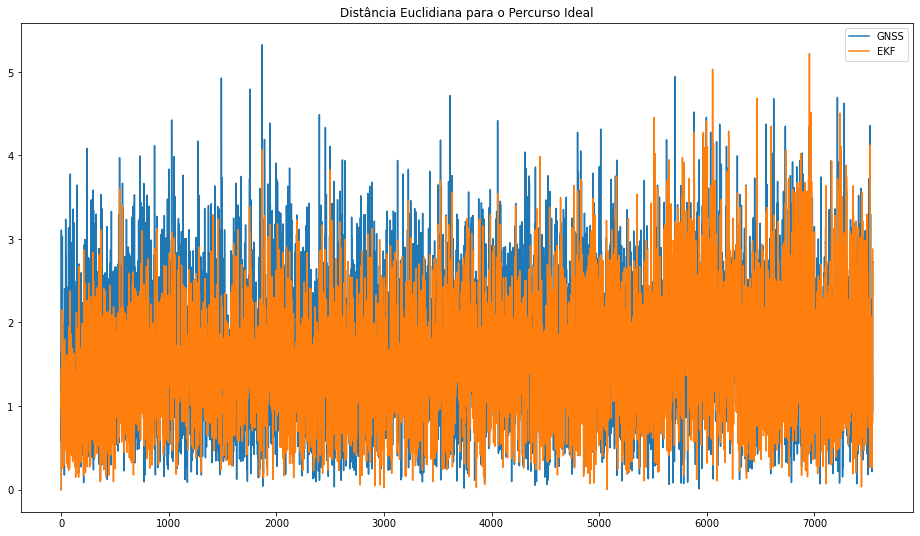

In [52]:
fig = plt.figure(figsize=(16,9))
plt.plot(dmp, label='GNSS')
plt.plot(dep, label='EKF')
plt.title("Distância Euclidiana para o Percurso Ideal")
plt.legend(loc='best')
plt.savefig('Comparação Distâncias Euclidianas para o Ground Truth.png', dpi=72, transparent=True, bbox_inches='tight')

<Figure size 432x288 with 0 Axes>

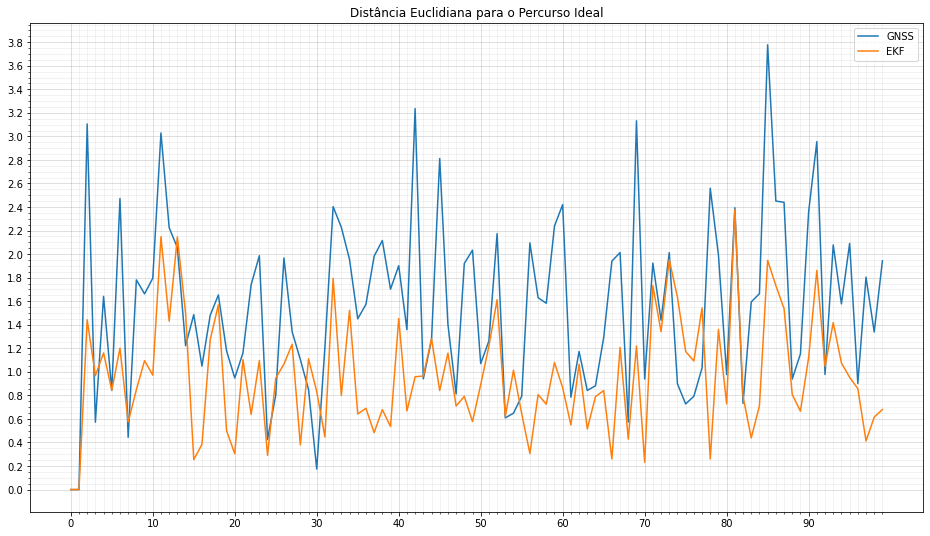

<Figure size 432x288 with 0 Axes>

In [53]:
# Gráfico com eixos ajustados para análise de dados
fig = plt.figure(figsize=(16,9))

ax = fig.add_subplot(1, 1, 1)

y_major_ticks = np.arange(0, 4.0, 0.2)
y_minor_ticks = np.arange(0, 4.0, 0.05)
x_major_ticks = np.arange(0, 100, 10)
x_minor_ticks = np.arange(0, 100, 1)

ax.set_xticks(x_major_ticks)
ax.set_xticks(x_minor_ticks, minor=True)
ax.set_yticks(y_major_ticks)
ax.set_yticks(y_minor_ticks, minor=True)

ax.grid(which='minor', alpha=0.2)
ax.grid(which='major', alpha=0.5)

plt.plot(dmp[0:100], label='GNSS')
plt.plot(dep[0:100], label='EKF')
plt.title("Distância Euclidiana para o Percurso Ideal")
plt.legend(loc='best')
plt.figure()

In [54]:
# Estatísticas

## Devio Padrão
std_GPS = stats.tstd(dmp[0:100])
std_EKF = stats.tstd(dep[0:100])

# Média, Variância, Erro máximo e Erro mínimo
print("Medição")
print("std_dev =",std_GPS)
#print(stats.describe(dm))
print(stats.describe(dmp[0:100]))
print()
print("Estimação")
print("std_dev =",std_EKF)
#print(stats.describe(de))
print(stats.describe(dep[0:100]))

Medição
std_dev = 0.7430356019596824
DescribeResult(nobs=100, minmax=(0.0, 3.7780479987677236), mean=1.5612409221691965, variance=0.5521019057795876, skewness=0.3684407474811461, kurtosis=-0.03651044666903358)

Estimação
std_dev = 0.4893925729580533
DescribeResult(nobs=100, minmax=(0.0, 2.3776691585112086), mean=0.9705285367695521, variance=0.2395050904665035, skewness=0.5134360180714816, kurtosis=0.009380400641059605)
